In [1]:
import os
import numpy as np
import keras
from keras.applications import ResNet50V2
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import optimizers
import matplotlib.pyplot as plt
import cv2
from keras.layers import Dropout
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import csv
import pandas as pd

Using TensorFlow backend.
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\idong\Anaconda3\envs\tens_gpu

In [3]:
base_dir = r'D:\dataset\dental\data'

data = np.load(base_dir + '\\data_KNU_Diorco_so_imgs.npy')
label_csv= open(base_dir + '\\data_KNU_Diorco_so_img_labels.csv', 'r')
label = csv.reader(label_csv)

In [3]:
right_label = []
left_label = []

for line in label:
    right_label.append(line[3])
    left_label.append(line[4])

right_label = right_label[1:]
left_label = left_label[1:]

right_label = list(map(int, right_label))
left_label = list(map(int, left_label))

right_label = np.array(right_label)
left_label = np.array(left_label)

np.save(base_dir + '\\right_label_2.npy', right_label)
np.save(base_dir + '\\left_label_2.npy', left_label)

In [4]:
right_label = np.load(base_dir + '\\right_label.npy')
left_label = np.load(base_dir + '\\left_label.npy')

right = data[:,:,:, 0:3]
left = data[:,:,:, 3:7]

In [5]:
patient_datas = []
patient_labels = []

for i in range(0, 797, 2):
    tmp_data = []
    tmp_data.append(left[i])
    tmp_data.append(right[i])
    tmp_data.append(left[i+1])
    tmp_data.append(right[i+1])
    patient_datas.append(tmp_data)
    
    tmp_label = []
    tmp_label.append(left_label[i])
    tmp_label.append(right_label[i])
    tmp_label.append(left_label[i+1])
    tmp_label.append(right_label[i+1])
    patient_labels.append(tmp_label)

    
for k in range(799, 808, 2):
    tmp_data = []
    tmp_data.append(left[k])
    tmp_data.append(right[k])
    tmp_data.append(left[k+1])
    tmp_data.append(right[k+1])
    patient_datas.append(tmp_data)
    
    tmp_label = []
    tmp_label.append(left_label[k])
    tmp_label.append(right_label[k])
    tmp_label.append(left_label[k+1])
    tmp_label.append(right_label[k+1])
    patient_labels.append(tmp_label)

In [ ]:
np.save(r'D:\dataset\dental\data\preprocessing\patient_data_2.npy', patient_datas)
np.save(r'D:\dataset\dental\data\preprocessing\patient_label_2.npy', patient_labels)

In [5]:
patient_datas = np.load(r'D:\dataset\dental\data\preprocessing\patient_data_2.npy', allow_pickle=True)
patient_labels = np.load(r'D:\dataset\dental\data\preprocessing\patient_label_2.npy', allow_pickle=True)

In [6]:
train_data, test_data, train_label, test_label= train_test_split(patient_datas, patient_labels, test_size = 0.2, random_state = 123)
train_data, val_data, train_label, val_label = train_test_split(train_data, train_label, test_size = 0.2, random_state = 123)

In [7]:
train_label = np.array(train_label)
test_label = np.array(test_label)
val_label = np.array(val_label)

In [8]:
#원 핫 인코딩을 위해 label을 바꿈
one_hot_train_labels = to_categorical(train_label - 1)
one_hot_validation_labels = to_categorical(val_label - 1)
one_hot_test_labels = to_categorical(test_label - 1)

In [9]:
real_train = []
real_val = []
real_test = []

def flat_datas(data, data_name):
    for m in range(len(data)):
        for j in range(4):
            data_name.append(data[m][j])

flat_datas(train_data, real_train)
flat_datas(val_data, real_val)
flat_datas(test_data, real_test)

In [10]:
train_data = np.array(real_train)
val_data = np.array(real_val)
test_data = np.array(real_test)

In [11]:
print(test_data.shape)
print(train_data.shape)
print(val_data.shape)

(324, 480, 784, 3)
(1032, 480, 784, 3)
(260, 480, 784, 3)


In [12]:
real_train_l = []
real_val_l = []
real_test_l = []

def flat_labels(label, label_name):
    for m in range(len(label)):
        for j in range(4):
            label_name.append(label[m][j])

flat_labels(one_hot_train_labels, real_train_l)
flat_labels(one_hot_validation_labels, real_val_l)
flat_labels(one_hot_test_labels, real_test_l)

In [13]:
one_hot_train_labels = np.array(real_train_l)
one_hot_val_labels = np.array(real_val_l)
one_hot_test_labels = np.array(real_test_l)

In [14]:
train_data = train_data.astype(np.float32) / 127.5 - 1
test_data = test_data.astype(np.float32) / 127.5 - 1
val_data = val_data.astype(np.float32) / 127.5 - 1

In [15]:
datagen = ImageDataGenerator(rotation_range = 10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=False,
                                  vertical_flip=False,
                                  fill_mode='nearest'
                                 )

In [16]:
datagen = ImageDataGenerator(zca_whitening=True)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [23]:
callbacks_list_clf = [
    keras.callbacks.EarlyStopping(
        monitor='acc',
        patience = 19,
        mode = max
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real5_dental_ResNet50V2_clf.h5',
        monitor='val_acc',
        save_best_only=False,
        period = 1
    ),
    keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 10)
]

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras\callbacks\callbacks.py:788: RuntimeWarning: EarlyStopping mode <built-in function max> is unknown, fallback to auto mode.
  RuntimeWarning)


In [24]:
conv_base = ResNet50V2(weights = 'imagenet',
                 include_top = False,
                 input_shape = (480, 784, 3))

In [25]:
#conv_base동결
conv_base.trainable = False

In [26]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 15, 25, 2048)      23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 24,090,115
Trainable params: 525,315
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [39]:
history2 = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 40),
    steps_per_epoch=45,
    epochs = 50,
    callbacks= callbacks_list_clf,
    validation_data=(val_data, one_hot_val_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
45/45 [==============================] - 93s 2s/step - loss: 1.1230 - acc: 0.4204 - val_loss: 1.1191 - val_acc: 0.3885
Epoch 2/50
45/45 [==============================] - 77s 2s/step - loss: 1.0288 - acc: 0.4810 - val_loss: 1.0586 - val_acc: 0.4500
Epoch 3/50
45/45 [==============================] - 76s 2s/step - loss: 0.9884 - acc: 0.5140 - val_loss: 1.0511 - val_acc: 0.4308
Epoch 4/50
45/45 [==============================] - 76s 2s/step - loss: 0.9531 - acc: 0.5488 - val_loss: 1.0572 - val_acc: 0.4385
Epoch 5/50
45/45 [==============================] - 76s 2s/step - loss: 0.9210 - acc: 0.5617 - val_loss: 1.1140 - val_acc: 0.4115
Epoch 6/50
45/45 [==============================] - 77s 2s/step - loss: 0.8958 - acc: 0.5871 - val_loss: 1.1567 - val_acc: 0.4038
Epoch 7/50
45/45 [==============================] - 76s 2s/step - loss: 0.8722 - acc: 0.6048 - val_loss: 1.1146 - val_acc: 0.4115
Epoch 8/50
45/45 [==============================] - 77s 2s/step - loss: 0.8625 - acc: 0.61

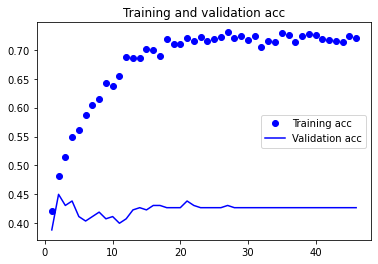

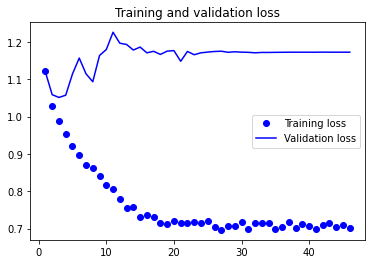

In [40]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model = models.load_model('real5_dental_ResNet50V2_clf.h5')
model.load_weights('real5_dental_ResNet50V2_clf.h5')

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [18]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == model.layers[0].layers[186].name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [19]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [20]:
callbacks_list_1 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 14,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real5_dental_ResNet50V2_1.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 10)
]

In [21]:
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [23]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 40),
    steps_per_epoch=45,
    epochs = 100,
    callbacks= callbacks_list_1,
    validation_data=(val_data, one_hot_val_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
45/45 [==============================] - 119s 3s/step - loss: 0.7074 - acc: 0.7243 - val_loss: 1.0430 - val_acc: 0.4885
Epoch 2/100
45/45 [==============================] - 95s 2s/step - loss: 0.6975 - acc: 0.7359 - val_loss: 0.9871 - val_acc: 0.5269
Epoch 3/100
45/45 [==============================] - 102s 2s/step - loss: 0.6726 - acc: 0.7506 - val_loss: 0.9645 - val_acc: 0.5423
Epoch 4/100
45/45 [==============================] - 113s 3s/step - loss: 0.6740 - acc: 0.7494 - val_loss: 0.9417 - val_acc: 0.5462
Epoch 5/100
45/45 [==============================] - 114s 3s/step - loss: 0.6676 - acc: 0.7382 - val_loss: 0.9330 - val_acc: 0.5538
Epoch 6/100
45/45 [==============================] - 119s 3s/step - loss: 0.6544 - acc: 0.7534 - val_loss: 0.9214 - val_acc: 0.5269
Epoch 7/100
45/45 [==============================] - 122s 3s/step - loss: 0.6438 - acc: 0.7634 - val_loss: 0.9265 - val_acc: 0.5654
Epoch 8/100
45/45 [==============================] - 126s 3s/step - loss: 0.6

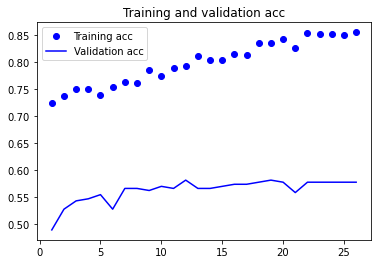

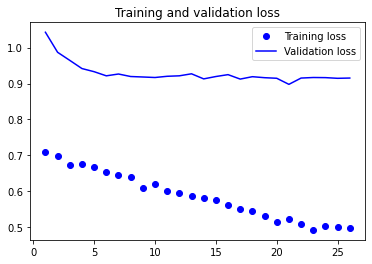

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
model = models.load_model('real5_dental_ResNet50V2_1.h5')
model.load_weights('real5_dental_ResNet50V2_1.h5')

In [17]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block3_2_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [18]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [19]:
callbacks_list_2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 14,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real5_dental_ResNet50V2_2.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 5
     )
] 

In [ ]:
model.compile(optimizer=optimizers.Adam(1e-6),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [22]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 30),
    steps_per_epoch=60,
    epochs = 100,
    callbacks= callbacks_list_2,
    validation_data=(val_data, one_hot_val_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
60/60 [==============================] - 96s 2s/step - loss: 0.5979 - acc: 0.7918 - val_loss: 0.9201 - val_acc: 0.5769
Epoch 2/100
60/60 [==============================] - 79s 1s/step - loss: 0.6001 - acc: 0.7806 - val_loss: 0.9191 - val_acc: 0.5692
Epoch 3/100
60/60 [==============================] - 79s 1s/step - loss: 0.5881 - acc: 0.8033 - val_loss: 0.9183 - val_acc: 0.5692
Epoch 4/100
60/60 [==============================] - 79s 1s/step - loss: 0.5831 - acc: 0.7942 - val_loss: 0.9173 - val_acc: 0.5692
Epoch 5/100
60/60 [==============================] - 80s 1s/step - loss: 0.5826 - acc: 0.8086 - val_loss: 0.9186 - val_acc: 0.5692
Epoch 6/100
60/60 [==============================] - 79s 1s/step - loss: 0.5703 - acc: 0.8173 - val_loss: 0.9162 - val_acc: 0.5692
Epoch 7/100
60/60 [==============================] - 82s 1s/step - loss: 0.5776 - acc: 0.7941 - val_loss: 0.9162 - val_acc: 0.5692
Epoch 8/100
60/60 [==============================] - 80s 1s/step - loss: 0.5761 - a

In [17]:
model = models.load_model('real5_dental_ResNet50V2_2.h5')
model.load_weights('real5_dental_ResNet50V2_2.h5')

In [18]:
model.layers[0].trainable = True

set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        print(layer)
    else:
        layer.trainable = False

In [19]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

print()
        
for layer in model.layers[0].layers:
    if layer.trainable:
        print(layer.name)

resnet50v2
global_average_pooling2d_1
dense_1
dropout_1
dense_2

conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu


In [20]:
callbacks_list_3 = [
    keras.callbacks.EarlyStopping(
        monitor='val_acc',
        patience = 14,
        mode = 'auto'
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='real5_dental_ResNet50V2_3.h5',
        monitor='val_acc',
        save_best_only=True,
        period = 1
    ),
     keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_acc',
    factor = 0.1,
    patience = 5
     )
] 

In [21]:
model.compile(optimizer=optimizers.Adam(1e-7),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [22]:
history = model.fit_generator(
    datagen.flow(train_data, one_hot_train_labels, batch_size = 30),
    steps_per_epoch=60,
    epochs = 100,
    callbacks= callbacks_list_3,
    validation_data=(val_data, one_hot_val_labels)
)

C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\idong\Anaconda3\envs\tens_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
60/60 [==============================] - 94s 2s/step - loss: 0.5950 - acc: 0.7789 - val_loss: 0.9207 - val_acc: 0.5769
Epoch 2/100
60/60 [==============================] - 81s 1s/step - loss: 0.5951 - acc: 0.7952 - val_loss: 0.9211 - val_acc: 0.5769
Epoch 3/100
60/60 [==============================] - 83s 1s/step - loss: 0.5898 - acc: 0.7885 - val_loss: 0.9212 - val_acc: 0.5769
Epoch 4/100
60/60 [==============================] - 80s 1s/step - loss: 0.6094 - acc: 0.7925 - val_loss: 0.9208 - val_acc: 0.5769
Epoch 5/100
60/60 [==============================] - 82s 1s/step - loss: 0.5963 - acc: 0.8008 - val_loss: 0.9210 - val_acc: 0.5731
Epoch 6/100
60/60 [==============================] - 82s 1s/step - loss: 0.5887 - acc: 0.7965 - val_loss: 0.9207 - val_acc: 0.5731
Epoch 7/100
60/60 [==============================] - 83s 1s/step - loss: 0.5827 - acc: 0.8010 - val_loss: 0.9209 - val_acc: 0.5731
Epoch 8/100
60/60 [==============================] - 83s 1s/step - loss: 0.6003 - a

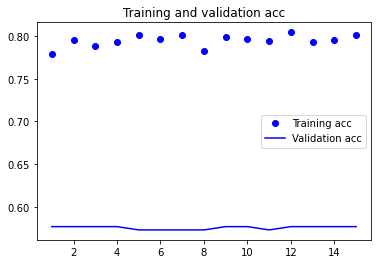

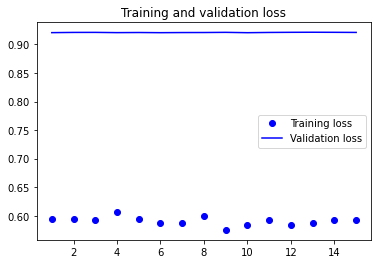

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_h = range(1, len(acc) + 1)

plt.plot(epochs_h, acc, 'bo', label='Training acc')
plt.plot(epochs_h, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs_h, loss, 'bo', label='Training loss')
plt.plot(epochs_h, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()